In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [7]:
## Dataset 2: churn prediction

##1. Decision trees
##2. Neural networks
##3. Boosted Decision trees
##4. SVM (Support vector machines)
##5. KNN (K-nearest neighbors)

In [41]:
# read data from csv
df=pd.read_csv("churn.csv")
print(df.head()) #first 5 rows

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [42]:
#check string columns and update format from string to num
Geography=df['Geography'].unique()
print('Geography: ',Geography)

Geography:  ['France' 'Spain' 'Germany']


In [43]:
df['Geography']=df['Geography'].replace({'France':1,'Spain':2,'Germany':3})
df['Gender']=df['Gender'].replace({'Female':1,'Male':2})
df = df.drop("Surname", axis='columns')
print(df.head())

   RowNumber  CustomerId  CreditScore  Geography  Gender  Age  Tenure  \
0          1    15634602          619          1       1   42       2   
1          2    15647311          608          2       1   41       1   
2          3    15619304          502          1       1   42       8   
3          4    15701354          699          1       1   39       1   
4          5    15737888          850          2       1   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0  


In [44]:
X = df.values[:,:-2] #columns and rows
y = df.values[:,-1] #target column
print("Number of positive samples: ", (y==1).sum())
print("Number of negative samples: ", (y==0).sum())
print("y shape: ", y.shape)
print("X shape: ", X.shape)

Number of positive samples:  2037
Number of negative samples:  7963
y shape:  (10000,)
X shape:  (10000, 11)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train.sum(), y_test.sum()

(1453.0, 584.0)

In [46]:
print(X_train)

[[9.0700000e+03 1.5777459e+07 6.1900000e+02 ... 2.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [2.6040000e+03 1.5583049e+07 6.4300000e+02 ... 1.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [7.7390000e+03 1.5768746e+07 5.6100000e+02 ... 2.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [5.3910000e+03 1.5573851e+07 7.3500000e+02 ... 3.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [8.6100000e+02 1.5807663e+07 6.6700000e+02 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [7.2710000e+03 1.5706268e+07 6.9700000e+02 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]]


In [47]:
##1. Decision trees
clf = tree.DecisionTreeClassifier() #load decision tree
clf.fit(X_train, y_train) #load training dataset
score=clf.score(X_test,y_test) #scoring using test dataset
print(score)

0.788


In [48]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = tree.DecisionTreeClassifier()
parameters = {'max_depth': [1,2,3,4,5,6,7,8,9], #using different comb to find best parameters
              'max_leaf_nodes':range(20),
              'criterion':['gini','entropy'],
              'min_samples_leaf':range(15)}
gs = GridSearchCV(clf, parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
CPU times: user 4.9 s, sys: 606 ms, total: 5.51 s
Wall time: 32.6 s


/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4320 fits failed out of a total of 27000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1350 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/Users/a2085/anaconda3/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/Users/a2085/anaconda3/l

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': range(0, 20),
                         'min_samples_leaf': range(0, 15)},
             verbose=1)

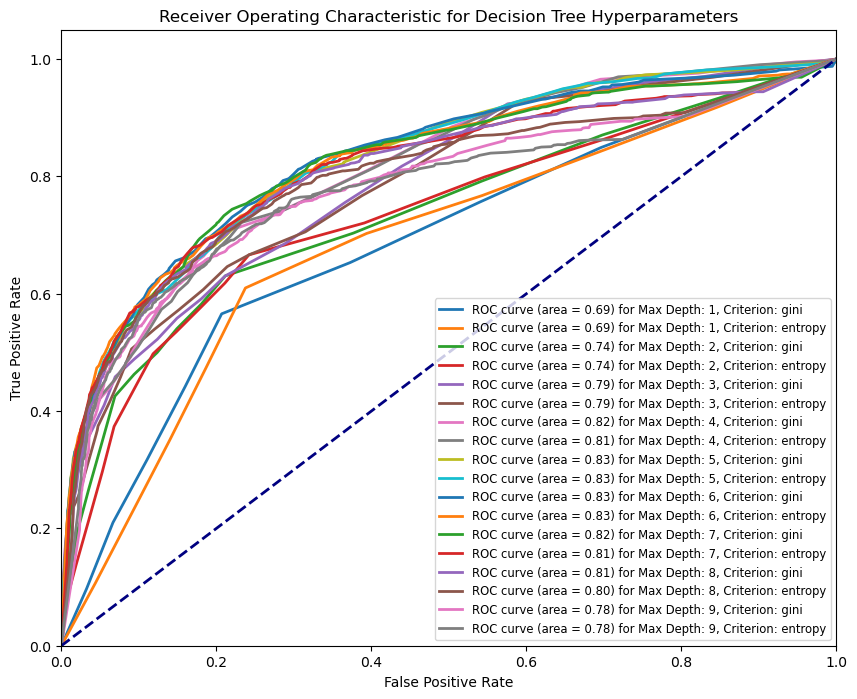

In [49]:
parameter_grid = {'max_depth': [1,2,3,4,5,6,7,8,9], 
              'criterion':['gini','entropy']
              }

parameter_combinations = list(itertools.product(*(parameter_grid[parameter] for parameter in parameter_grid)))

# Prepare to plot ROC curves
plt.figure(figsize=(10, 8))

# Iterate over each combination of parameters
for parameters in parameter_combinations:
    
    max_depth, criterion = parameters
    
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    
    y_probas = cross_val_predict(clf, X_train, y_train, cv=5, method='predict_proba')
    
    fpr, tpr, _ = roc_curve(y_train, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for Max Depth: %d, Criterion: %s' % (roc_auc, max_depth, criterion))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Decision Tree Hyperparameters')
plt.legend(loc="lower right", fontsize='small')
plt.show()

In [50]:
gs.best_score_ #best score

0.8539999999999999

In [51]:
gs.best_params_ #best score parameters

{'criterion': 'gini',
 'max_depth': 7,
 'max_leaf_nodes': 19,
 'min_samples_leaf': 10}

In [52]:
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=7,
                                  max_leaf_nodes=19,
                                  min_samples_leaf=10) #load decision tree with optimized parameters
clf.fit(X_train, y_train) #load training dataset
score=clf.score(X_test,y_test) #scoring using test dataset
print(score)

0.8616666666666667


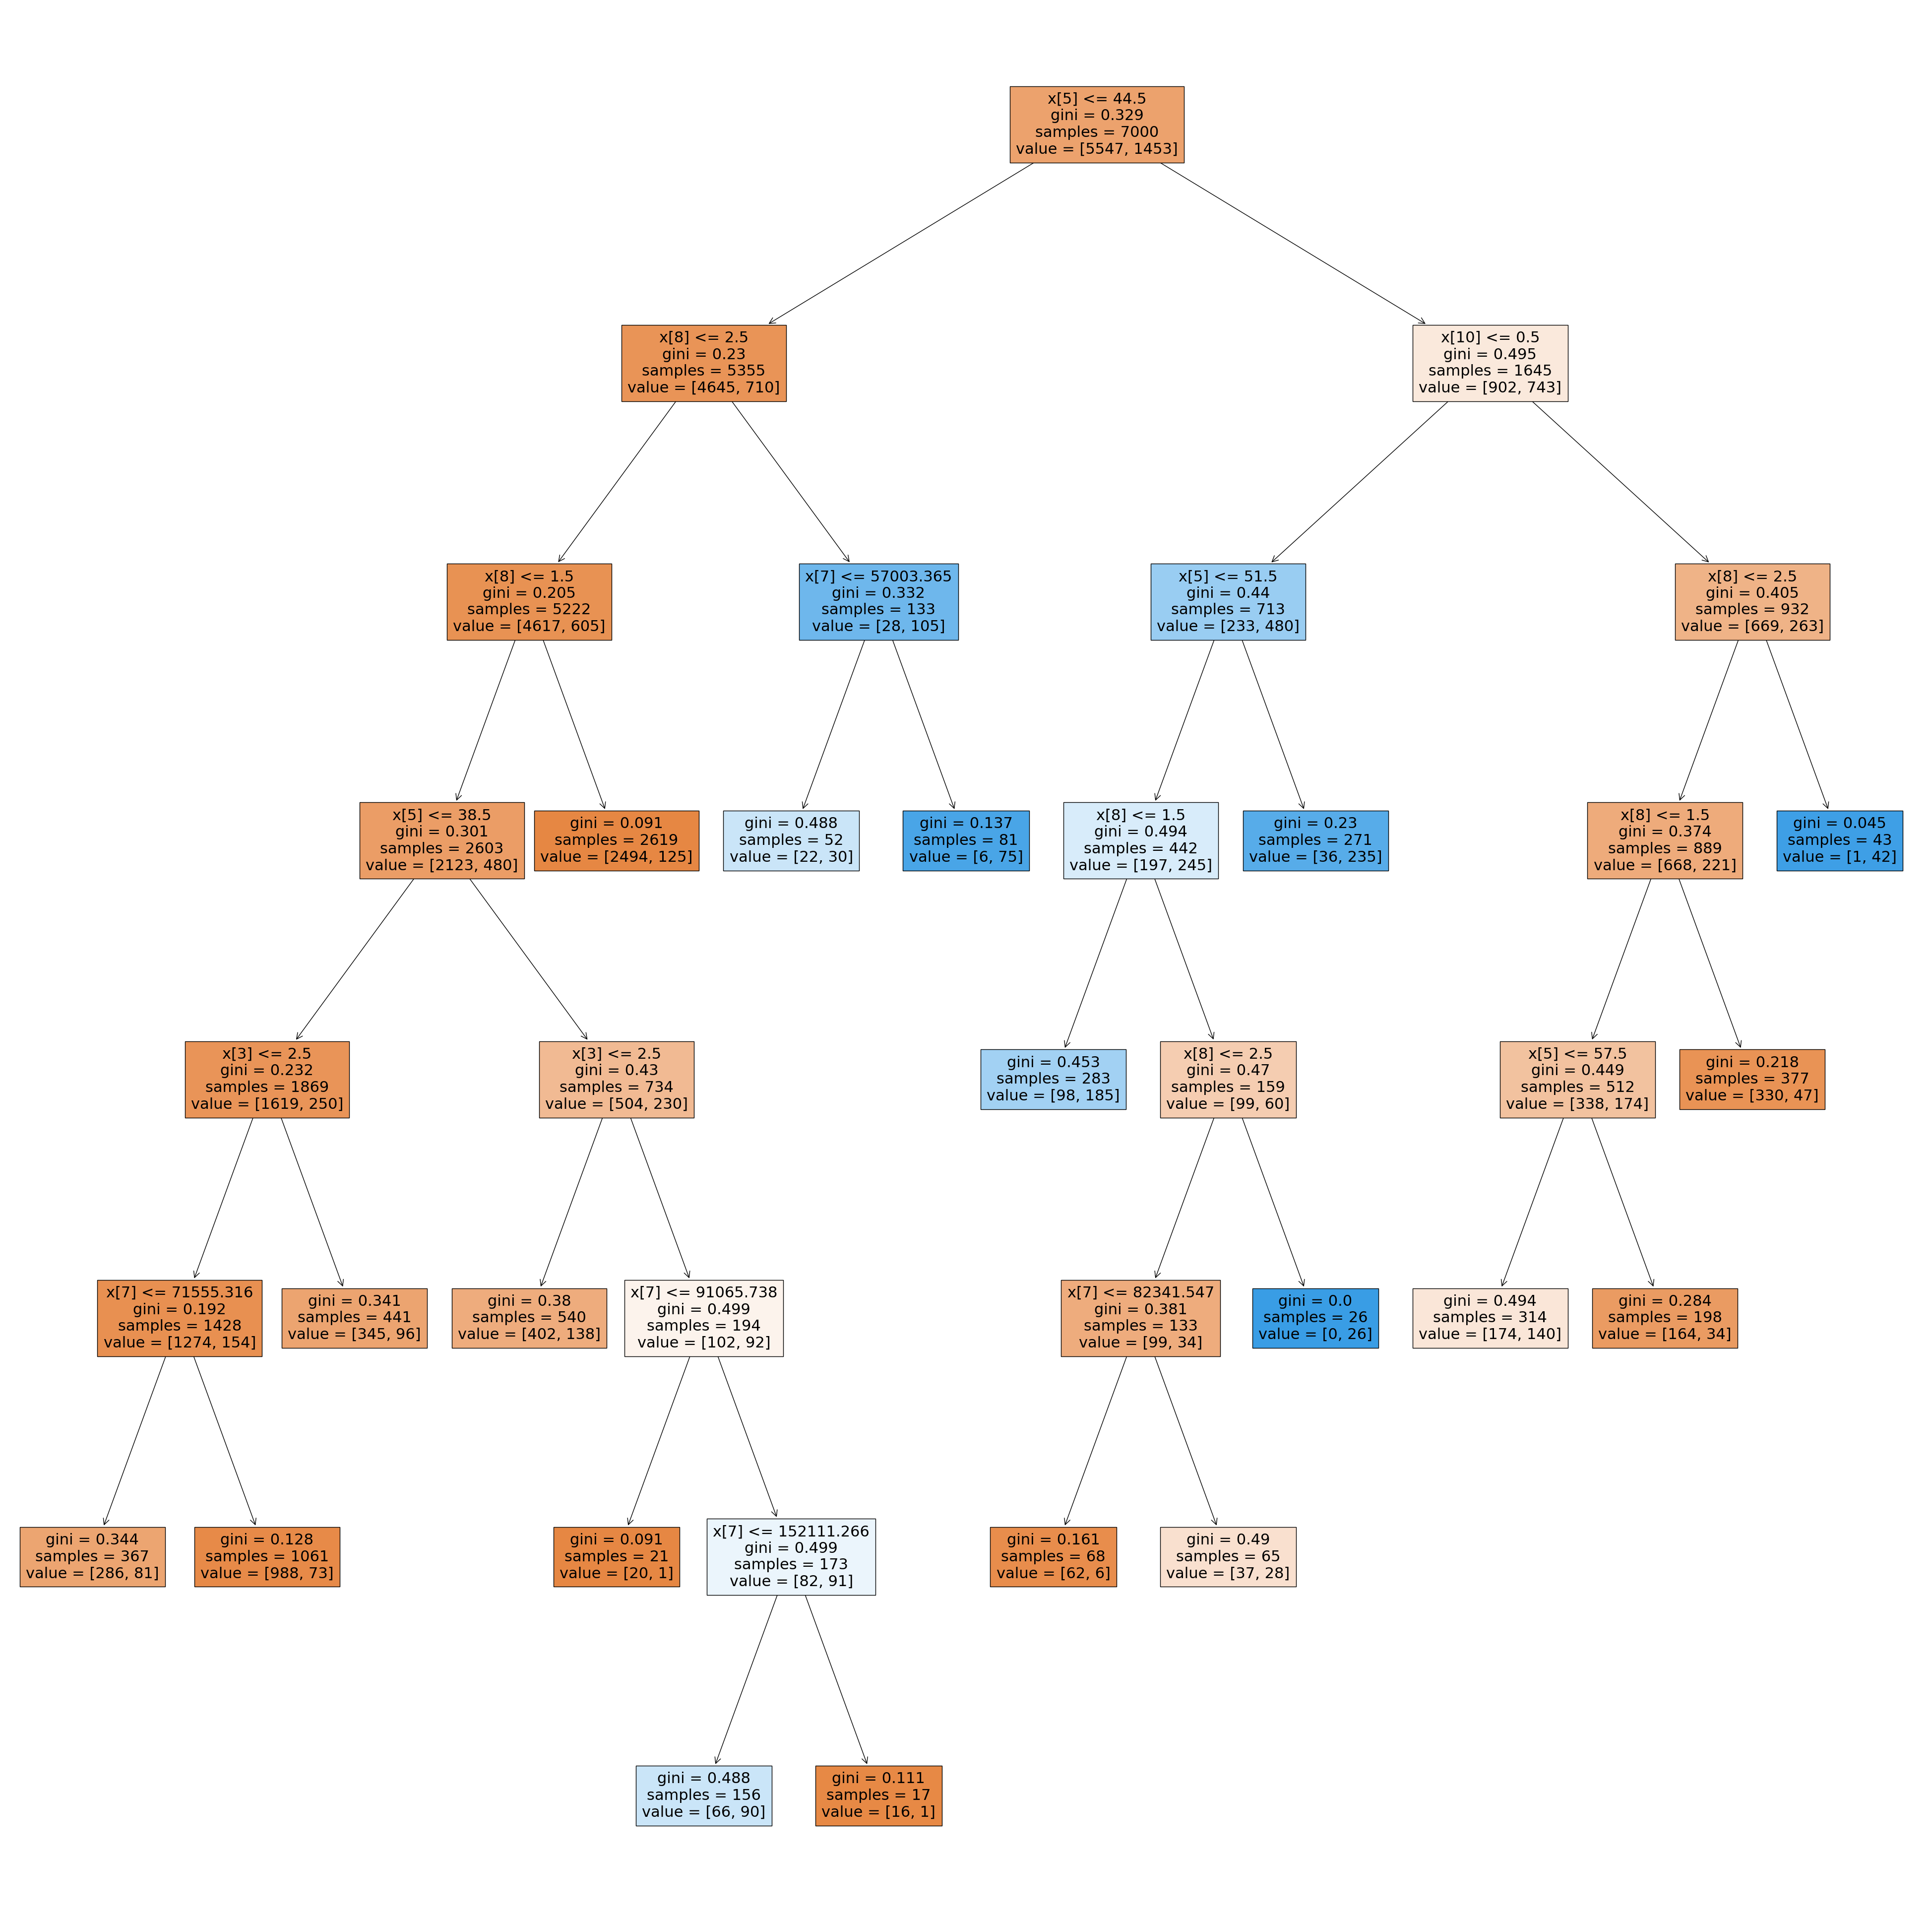

In [53]:
plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, filled=True)
plt.show()

In [54]:
#Final train and test scores
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=7,
                                  max_leaf_nodes=19,
                                  min_samples_leaf=10) #load decision tree with optimized parameters
clf.fit(X_train, y_train) #load training dataset
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_test_predict))
print("Train: ", roc_auc_score(y_train, y_train_predict))

Test:  0.707665222716139
Train:  0.7143891820519912


In [32]:
## 2. Neural networks

In [82]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
# Standardizing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=False)

In [85]:
# Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model = NeuralNetwork(X_train.shape[1]).to(device)

In [86]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 30
for epoch in tqdm(range(num_epochs)):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 26.22it/s]


In [87]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred_labels = y_pred.round()
    test_auc = roc_auc_score(y_test.cpu(), y_pred_labels.cpu())
    print(f'Test ROC AUC Score: {test_auc}')

Test ROC AUC Score: 0.7338122561915994


In [80]:
# Find best hyper parameters

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1) 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

def train_and_evaluate_model(params):
    hidden_size, learning_rate, batch_size = params
    model = NeuralNetwork(X_train.shape[1], hidden_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs): 
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    with torch.no_grad():
        outputs = model(X_test)
        auc_score = roc_auc_score(y_test.detach().numpy(), outputs.squeeze().detach().numpy())
    return auc_score

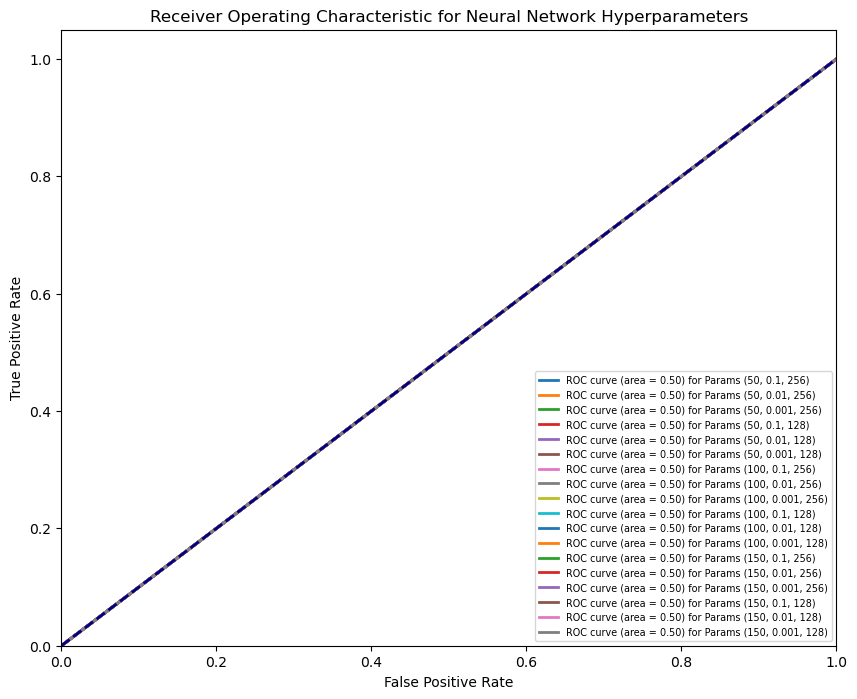

In [81]:
# Select different combinations of hyper parameters for ROC comparison
grid = [(50, 0.1, 256), 
        (50, 0.01, 256),
        (50, 0.001, 256),
        (50, 0.1, 128), 
        (50, 0.01, 128),
        (50, 0.001, 128),

        
        (100, 0.1, 256), 
        (100, 0.01, 256),
        (100, 0.001, 256),
        (100, 0.1, 128), 
        (100, 0.01, 128),
        (100, 0.001, 128),

        
        (150, 0.1, 256), 
        (150, 0.01, 256),
        (150, 0.001, 256),
        (150, 0.1, 128), 
        (150, 0.01, 128),
        (150, 0.001, 128),

       
       ]

# Adjusted training and evaluation function to include device handling
def train_and_evaluate_model(params, X_train, y_train, X_test, y_test, device):
    hidden_size, learning_rate, batch_size = params
    model = NeuralNetwork(X_train.shape[1], hidden_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert data to tensors and move to the designated device
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)  # y_test is used later for roc_curve which expects numpy array
    
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    num_epochs = 5  # Reduced for demonstration
    for epoch in range(num_epochs):
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze()
        y_pred_proba = outputs.cpu().numpy()  # Move data back to CPU for sklearn metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example data conversion (ensure X_train, y_train, X_test, y_test are correctly prepared before this step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Iterate over each combination of parameters and collect ROC metrics
fprs, tprs, aucs = [], [], []
for params in grid:
    fpr, tpr, roc_auc = train_and_evaluate_model(params, X_train, y_train, X_test, y_test, device)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

# Plotting ROC curves
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs, tprs, aucs)):
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for Params %s' % (roc_auc, str(grid[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network Hyperparameters')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [80]:
## 3. Boosting Decision tree


In [88]:
##data loader
import xgboost as xgb
X = df.drop(['Exited'], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  0.9488412912940298
Test AUC:  0.7179873900027216


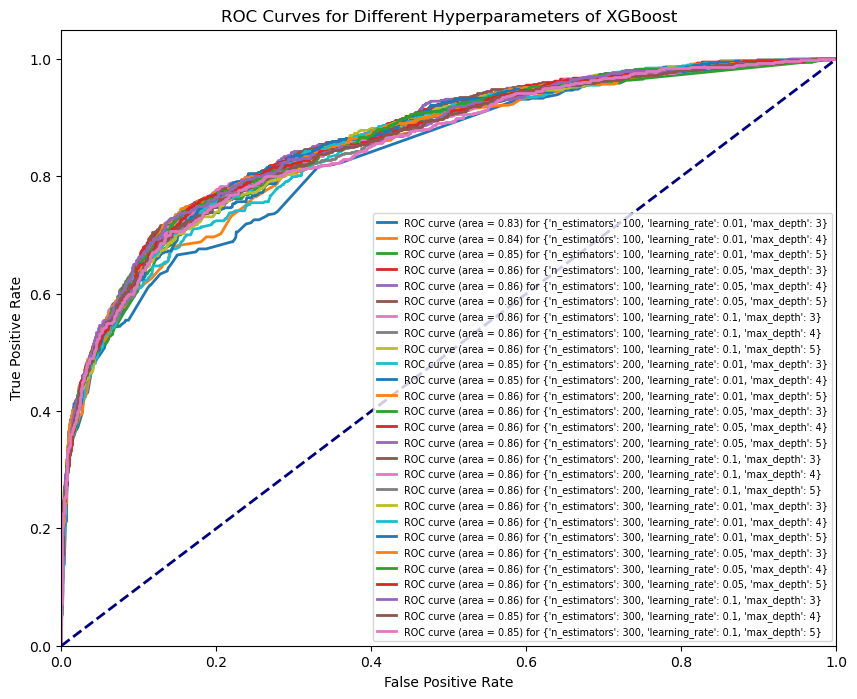

In [92]:
import xgboost as xgb
def train_model_and_get_roc(X_train, y_train, X_test, y_test, params):
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters grid setup (simplified for illustration)
parameter_combinations = list(itertools.product(
    parameters['n_estimators'],
    parameters['learning_rate'],
    parameters['max_depth']
))

# Plot setup
plt.figure(figsize=(10, 8))

# Iterate over parameter combinations
for combination in parameter_combinations:
    param_dict = {
        'n_estimators': combination[0],
        'learning_rate': combination[1],
        'max_depth': combination[2]
    }
    fpr, tpr, roc_auc = train_model_and_get_roc(X_train, y_train, X_test, y_test, param_dict)
    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f) for %s' % (roc_auc, param_dict))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of XGBoost')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [91]:
#find best hyper parameters
import xgboost as xgb
X = df.drop(['Exited'], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


parameters = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'colsample_bytree': [0.7, 0.8],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.7, 0.8]  # Subsample ratio of the training instances
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(xgb_classifier,parameters, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC: ", test_auc)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best AUC found:  0.8646747258969221
Test AUC:  0.703928717227615


In [93]:

#retrain the model with optimized hyper parameters
import xgboost as xgb
X = df.drop(['Exited'], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
xgb = xgb.XGBClassifier(use_label_encoder=False, 
                        eval_metric='logloss',
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        max_depth=5,
                        n_estimators=300,
                        subsample=0.8
                        )
xgb.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  0.7176352960020923
Test AUC:  0.703928717227615


In [102]:
##4.SVM

In [94]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier
svm_clf = SVC(probability=True)  # probability=True to use roc_auc_score later

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  0.6977996079550947
Test AUC:  0.6794855075750703


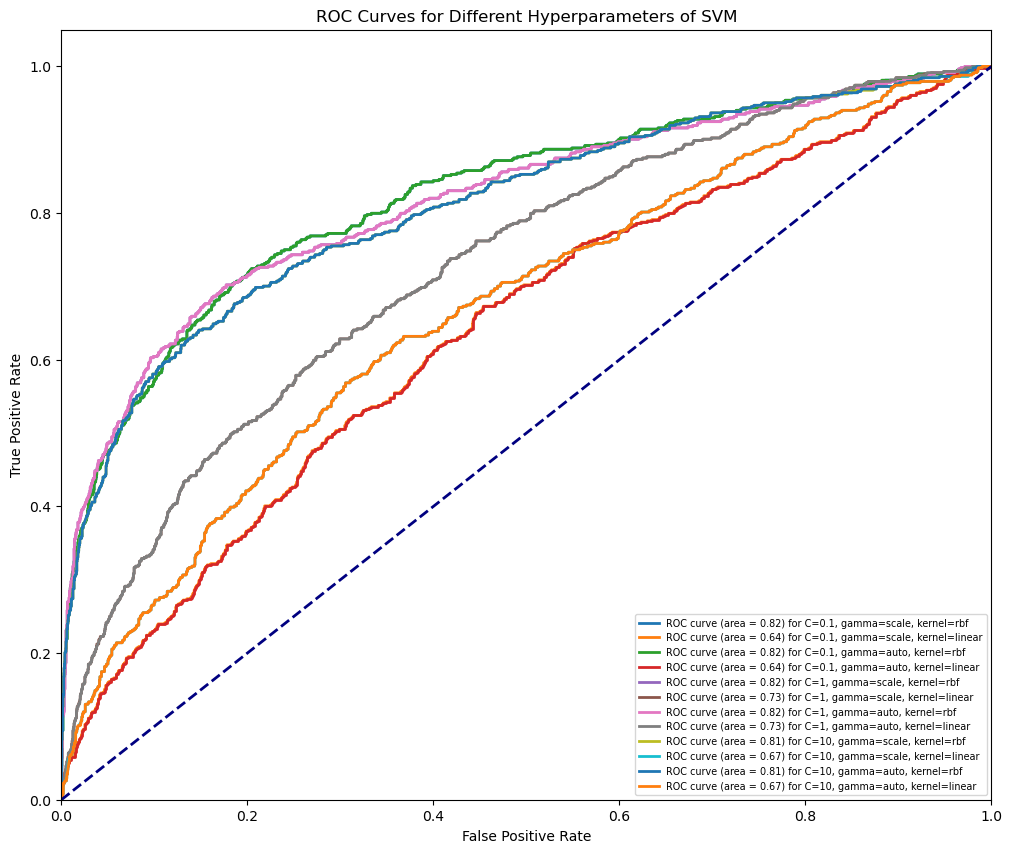

In [95]:
def train_svm_and_compute_roc(X_train, y_train, X_test, y_test, params):
    svm_clf = SVC(probability=True, **params)
    svm_clf.fit(X_train, y_train)
    y_scores = svm_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters for hyperparameter tuning
parameters = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Generate all combinations of parameters
parameter_combinations = list(itertools.product(parameters['C'], parameters['gamma'], parameters['kernel']))

# Plot setup
plt.figure(figsize=(12, 10))

# Iterate over parameter combinations
for combo in parameter_combinations:
    params = {'C': combo[0], 'gamma': combo[1], 'kernel': combo[2]}
    fpr, tpr, roc_auc = train_svm_and_compute_roc(X_train_scaled, y_train, X_test_scaled, y_test, params)
    label = f'ROC curve (area = {roc_auc:.2f}) for C={params["C"]}, gamma={params["gamma"]}, kernel={params["kernel"]}'
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of SVM')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [96]:
# Hyperparameter tuning using GridSearchCV
parameters = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['rbf', 'linear']  # Specifies the kernel type to be used in the algorithm
}

grid_search = GridSearchCV(SVC(probability=True), parameters, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC with best parameters: ", test_auc)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best AUC found:  0.8222587205387685
Test AUC with best parameters:  0.5749569082826816


In [97]:
# SVM Classifier
svm_clf = SVC(probability=True,
              C=0.1,
              gamma='auto',
              kernel='rbf'
             ) 

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)

Training AUC:  0.5818337597091537
Test AUC:  0.5749569082826816


In [110]:
##5. KNN

In [98]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN Classifier
knn_clf = KNeighborsClassifier()

# Train the model
knn_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = knn_clf.predict(X_train_scaled)
y_test_pred = knn_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  0.7290557534308272
Test AUC:  0.646012882155493


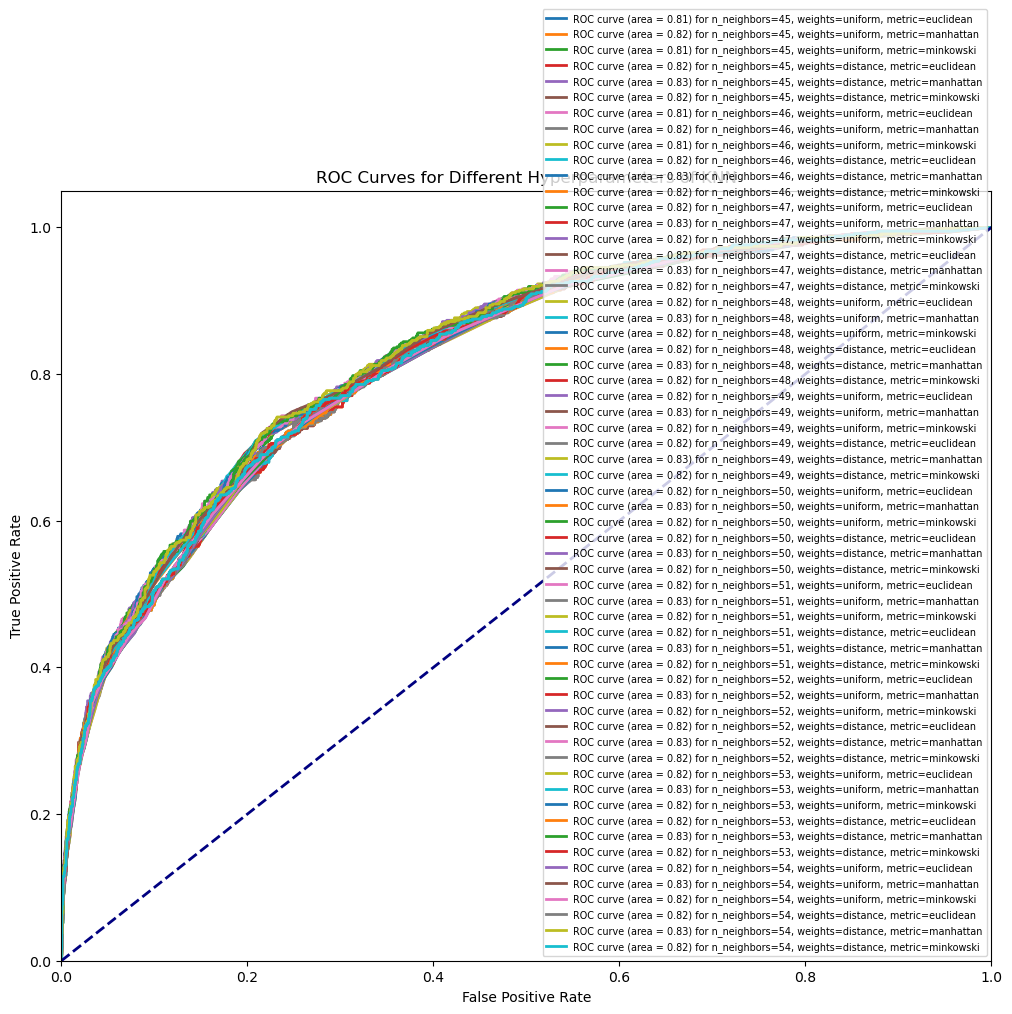

In [102]:
## ROC curves plot
def train_knn_and_compute_roc(X_train, y_train, X_test, y_test, params):
    knn_clf = KNeighborsClassifier(**params)
    knn_clf.fit(X_train, y_train)
    # For KNN, using predict_proba to get scores for ROC curve
    y_scores = knn_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Parameters for hyperparameter tuning
parameters = {
    'n_neighbors': range(45, 55),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Generate all combinations of parameters
parameter_combinations = list(itertools.product(
    parameters['n_neighbors'],
    parameters['weights'],
    parameters['metric']
))

# Plot setup
plt.figure(figsize=(12, 10))

# Iterate over parameter combinations
for combo in parameter_combinations:
    params = {'n_neighbors': combo[0], 'weights': combo[1], 'metric': combo[2]}
    fpr, tpr, roc_auc = train_knn_and_compute_roc(X_train_scaled, y_train, X_test_scaled, y_test, params)
    label = f'ROC curve (area = {roc_auc:.2f}) for n_neighbors={params["n_neighbors"]}, weights={params["weights"]}, metric={params["metric"]}'
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Hyperparameters of KNN')
plt.legend(loc="lower right", fontsize='x-small')
plt.show()


In [101]:

# Hyperparameter tuning using GridSearchCV
parameters = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUC found: ", grid_search.best_score_)

# Use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
y_test_pred = best_estimator.predict(X_test_scaled)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Test AUC with best parameters: ", test_auc)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}
Best AUC found:  0.8263787146318293
Test AUC with best parameters:  0.5917513381112219


In [103]:
# Retain with best hyper parameters
knn_clf = KNeighborsClassifier(metric='manhattan',
                              n_neighbors=49,
                              weights='distance')

# Train the model
knn_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_train_pred = knn_clf.predict(X_train_scaled)
y_test_pred = knn_clf.predict(X_test_scaled)

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("Training AUC: ", train_auc)
print("Test AUC: ", test_auc)


Training AUC:  1.0
Test AUC:  0.5917513381112219
